In [94]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.ardl import UECM
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.datasets import danish_data
from statsmodels.tsa.tsatools import add_trend, lagmat, lagmat2ds
from statsmodels.tsa.adfvalues import mackinnoncrit, mackinnonp

from statsmodels.tools.validation import (
    array_like,
    bool_like,
    dict_like,
    float_like,
    int_like,
    string_like,
)

In [178]:
from statsmodels.datasets import danish_data as data
df = data.load_pandas().data[1:]
print(df.columns)
coint(df[df.columns[0]], df[['lry', 'ibo']])

Index(['lrm', 'lry', 'lpy', 'ibo', 'ide'], dtype='object')


(-3.705817512135864,
 0.05469424768816511,
 array([-4.57760481, -3.90590515, -3.57075455]))

In [179]:
# helper functions
def adf_series(series):
    """
    Perform ADF test and print results
    """
    results = adfuller(series)
    print(f'p-value: {results[1]}')
    if results[1] < 0.05:
        print('conclusion: Series is stationary')
    else:
        print('conclusion: Series is not stationary')

def adf_df(df):
    for i in df.columns:
        print(f' - ADF test for column "{i}":')
        adf_series(df[i])

In [180]:
df = danish_data.load_pandas().data
adf_df(df)

 - ADF test for column "lrm":
p-value: 0.43014127613057024
conclusion: Series is not stationary
 - ADF test for column "lry":
p-value: 0.7524010356872576
conclusion: Series is not stationary
 - ADF test for column "lpy":
p-value: 0.03127456749737955
conclusion: Series is stationary
 - ADF test for column "ibo":
p-value: 0.4565549115432146
conclusion: Series is not stationary
 - ADF test for column "ide":
p-value: 0.13237410704936003
conclusion: Series is not stationary


In [181]:
lr = OLS(df['lrm'], sm.add_constant(df[['lry','ibo']]))
results = lr.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    lrm   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     320.8
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           5.59e-30
Time:                        01:55:14   Log-Likelihood:                 97.189
No. Observations:                  55   AIC:                            -188.4
Df Residuals:                      52   BIC:                            -182.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4676      0.574      7.780      0.0

In [182]:
residuals = results.resid
adf_series(residuals)

p-value: 0.011923214361739617
conclusion: Series is stationary


<Axes: xlabel='period'>

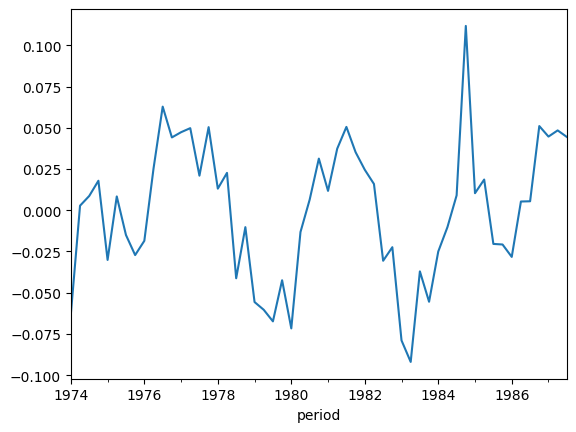

In [183]:
residuals.plot()

In [184]:
df['lrm_diff'] = df['lrm'].diff()
df['lry_diff'] = df['lry'].diff()
df['ibo_diff'] = df['ibo'].diff()
df['res_lag'] = residuals.shift(1)

In [185]:
sr = OLS(df['lrm_diff'][1:], sm.add_constant(df[['lry_diff', 'ibo_diff','res_lag']][1:]))
results = sr.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               lrm_diff   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     15.56
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           2.81e-07
Time:                        01:55:20   Log-Likelihood:                 125.66
No. Observations:                  54   AIC:                            -243.3
Df Residuals:                      50   BIC:                            -235.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.003      1.273      0.2

In [186]:
ecm1s = UECM(endog= df['lrm'], lags=1, exog=df[["lry", "ibo"]], order=1,causal=False)

In [187]:
results = ecm1s.fit()

In [188]:
print(results.summary())


                              UECM Model Results                              
Dep. Variable:                  D.lrm   No. Observations:                   55
Model:                  UECM(1, 1, 1)   Log Likelihood                 129.262
Method:               Conditional MLE   S.D. of innovations             11.751
Date:                Mon, 11 Nov 2024   AIC                           -244.524
Time:                        01:55:24   BIC                           -230.601
Sample:                    04-01-1974   HQIC                          -239.155
                         - 07-01-1987                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8143      0.477      3.803      0.000       0.855       2.773
lrm.L1        -0.2923      0.078     -3.741      0.000      -0.449      -0.135
lry.L1         0.3007      0.116      2.595      0.0